In [15]:
import numpy as np
from scipy import stats
import math
import os

In [16]:
FOLDER = "ChaCha-100-000-Random-Nonce-XMEGA"

# Load the content of files 

In [17]:
NONCE_LEN_BYTES = 12
TRACE_CNT = None
TRACE_LEN = None
TRACE_RANDOM_CNT = None
CHUNK_SIZE = None
CHUNKS_CNT = None
LAST_CHUNK_SIZE = None
def read_info(folder):
    global CHUNK_SIZE, LAST_CHUNK_SIZE
    global CHUNKS_CNT
    with open(f"{folder}/info.txt", 'r') as file:
        global TRACE_CNT
        global TRACE_LEN
        global TRACE_RANDOM_CNT
        TRACE_CNT = int(file.readline())
        TRACE_RANDOM_CNT = TRACE_CNT
        CHUNK_SIZE = int(file.readline())
        TRACE_LEN = int(file.readline())
        
    CHUNKS_CNT = math.ceil(TRACE_CNT / CHUNK_SIZE)
    LAST_CHUNK_SIZE = TRACE_CNT - (CHUNKS_CNT - 1)* CHUNK_SIZE
    print(f"TRACE_CNT = {TRACE_CNT}")   
    print(f"CHUNK_SIZE = {CHUNK_SIZE}")   
    print(f"LAST_CHUNK_SIZE = {LAST_CHUNK_SIZE}")   
    print(f"CHUNKS_CNT = {CHUNKS_CNT}")   
    print(f"TRACE_RANDOM_CNT = {TRACE_RANDOM_CNT}")   
    print(f"TRACE_LEN = {TRACE_LEN}")
    
    
read_info(FOLDER)

TRACE_CNT = 100000
CHUNK_SIZE = 10000
LAST_CHUNK_SIZE = 10000
CHUNKS_CNT = 10
TRACE_RANDOM_CNT = 100000
TRACE_LEN = 21304


In [18]:
NONCES = None
def read_nonces(folder):
    global NONCES
    global CHUNK_SIZE, LAST_CHUNK_SIZE
    global CHUNKS_CNT
    global TRACE_CNT
    # Calculate the number of chunks
    
    nonces_list = []
    for chunk_index in range(CHUNKS_CNT):
        chunk_folder = os.path.join(folder, f"chunk_{chunk_index}")
        chunk_file = os.path.join(chunk_folder, "nonces_random.bin")
        
        if os.path.exists(chunk_file):
            with open(chunk_file, 'rb') as file:
                byte_array = file.read()
            
            if chunk_index != CHUNKS_CNT-1:
                chunk = np.frombuffer(byte_array, dtype=np.uint8).reshape((CHUNK_SIZE, NONCE_LEN_BYTES))
            else:
                chunk = np.frombuffer(byte_array, dtype=np.uint8).reshape((LAST_CHUNK_SIZE, NONCE_LEN_BYTES))

            nonces_list.append(chunk)
        else:
            print(f"Chunk file {chunk_file} does not exist.")
    
    # Concatenate all chunks
    NONCES = np.vstack(nonces_list)
        
    # Desired shape
    desired_shape = (TRACE_CNT, NONCE_LEN_BYTES)

    # Check if the array has the desired shape
    if NONCES.shape != desired_shape:
        # Trim the array to the desired shape
        print(f"NONCES.shape != desired_shape - {NONCES.shape} != {desired_shape}")
        NONCES = NONCES[:desired_shape[0], :desired_shape[1]]
        print(f"Trimming NONCES to {NONCES.shape}")
        
    nonce = NONCES[0]

    # Convert each byte to its hexadecimal representation and join them
    hex_representation = ''.join(f'{byte:02x}' for byte in nonce[:12])

    # Print the result
    print(f"Nonce[0] = {hex_representation}")
    
    
read_nonces(FOLDER)

Nonce[0] = 25cc4792cfd34a0418243218


In [19]:
#load the correct key
correct_key = np.fromfile(f"{FOLDER}/key.bin", dtype=np.uint8)
hex_key = ''.join(f'{byte:02x}' for byte in correct_key)
print(f"Correct Key: {hex_key}")


Correct Key: 3afa3f58fbc0f2bc68e5ac304bb50e43833971578b132a87d9621f51b1f4e6e0


In [20]:
TRACES_RANDOM = None

def load_traces_random(folder):
    global TRACES_RANDOM, CHUNK_SIZE, LAST_CHUNK_SIZE, CHUNKS_CNT, TRACE_CNT

    traces_list = []
    for chunk_index in range(CHUNKS_CNT):
        chunk_folder = os.path.join(folder, f"chunk_{chunk_index}")
        chunk_file = os.path.join(chunk_folder, "traces_random.bin")

        if os.path.exists(chunk_file):
            with open(chunk_file, 'rb') as file:
                byte_array = file.read()

            if chunk_index != CHUNKS_CNT-1:
                chunk_traces = np.frombuffer(byte_array, dtype=np.uint16).reshape((CHUNK_SIZE, TRACE_LEN))
            else:
                chunk_traces = np.frombuffer(byte_array, dtype=np.uint16).reshape((LAST_CHUNK_SIZE, TRACE_LEN))

            traces_list.append(chunk_traces)
        else:
            print(f"Chunk file {chunk_file} does not exist.")

    # Concatenate all chunks
    TRACES_RANDOM = np.vstack(traces_list)

load_traces_random(FOLDER)

In [21]:
CHACHA_KEY_LEN_BYTES = 32
VALUES_IN_BYTE = 256 #0...255

# constant sigma - 16B - "expand 32-byte k"
fixed_sigma = bytearray("expand 32-byte k", "utf-8")
print(hex(fixed_sigma[4]))

0x6e


<IPython.core.display.Javascript object>


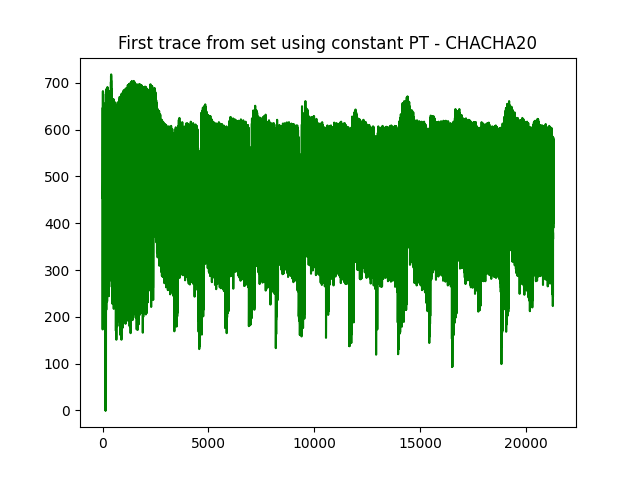

In [22]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure()
plt.title(f'First trace from set using constant PT - CHACHA20')
plt.plot(TRACES_RANDOM[0], 'g')
# plt.plot(range(4600, 6100), TRACES_RANDOM[490][4600:6100], 'r')
plt.show()


# Adjust size of traces

In [23]:
# STM32 - Trim TRACES_RANDOM to have only the first 23 traces
# TRACE_CNT = 23
# TRACES_RANDOM = TRACES_RANDOM[:TRACE_CNT, :]

In [24]:
# Crop every trace (row) to sample range 0..1499
TRACE_CNT = 5000
TRACES_RANDOM = TRACES_RANDOM[:TRACE_CNT, :]
TRACES_RANDOM = TRACES_RANDOM[:, 4500:6501]

NONCES= NONCES[:TRACE_CNT, :]

In [25]:
print(f"TRACES shape = {TRACES_RANDOM.shape}")

TRACES shape = (5000, 2001)


# DPA using t-test

In [26]:
hex(correct_key[4])

'0xfb'

In [27]:
bin(correct_key[4])

'0b11111011'

In [28]:
import numpy as np
from scipy.stats import ttest_ind

...Processing 0. bit
First 10 rows and 15 columns of L_matrix - (5000, 8):
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
0x0 -  Greatest t-value: 41.73598879886645 at sample index: 922
0x1 -  Greatest t-value: 41.73598879886645 at sample index: 922
0x2 -  Greatest t-value: 41.73598879886645 at sample index: 922
0x3 -  Greatest t-value: 41.73598879886645 at sample index: 922
0x4 -  Greatest t-value: 41.73598879886645 at sample index: 922
0x5 -  Greatest t-value: 41.73598879886645 at sample index: 922
0x6 -  Greatest t-value: 41.73598879886645 at sample index: 922
0x7 -  Greatest t-value: 41.73598879886645 at sample index: 922
key = 01, max. t-value = 41.73598879886645
key = 03, max. t-value = 41.73598879886645
key = 05, max. t-value = 41.73598879886645
key = 07, max. t-value = 41.73598879886645
key = 00, max. t-value = -41.73598879886645
key = 02, max. t-value = -41.73598879

<IPython.core.display.Javascript object>


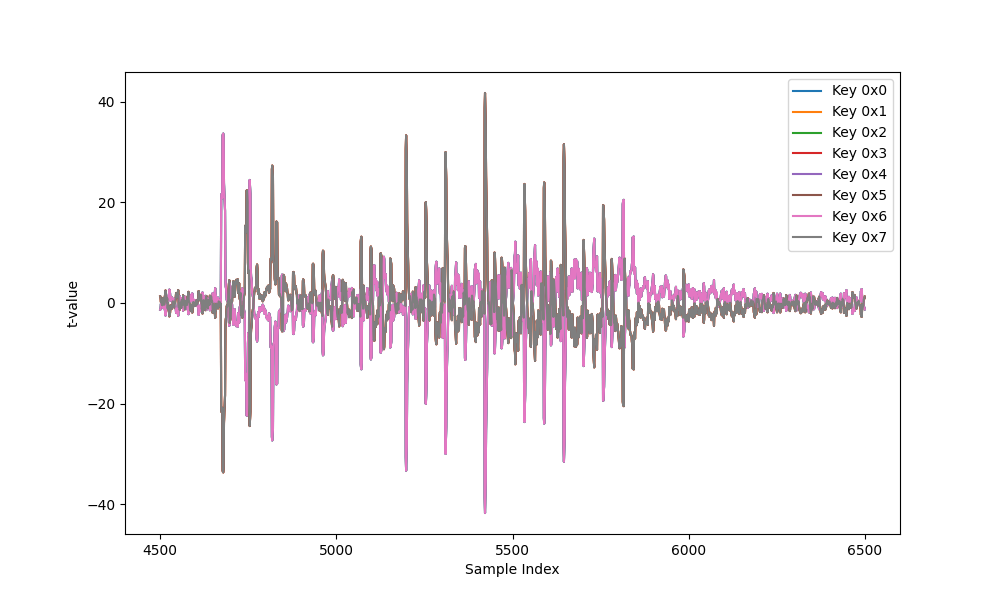

In [31]:
byte_pos = 4
bit_pos = 0

BYTE_VALUES = 8

L_matrix = np.empty((TRACE_CNT,BYTE_VALUES), dtype=np.byte)

print(f"...Processing {bit_pos}. bit")
for trace_number in range(TRACE_CNT):

    nonce_byte = NONCES[trace_number][byte_pos - 4]
    possible_values_vector = np.array([nonce_byte ^ ((possible_key_value + fixed_sigma[byte_pos]) & 0xFF) for possible_key_value in range(BYTE_VALUES)], dtype=np.byte)
    #extraction of X-th bit - [0000 000X] to [X000 0000]
    L_vector = np.array([ ((v1 & (0x01 << bit_pos)) >> bit_pos) for v1 in possible_values_vector], dtype=np.byte)
    L_matrix[trace_number, :] = L_vector

print(f"First 10 rows and 15 columns of L_matrix - {L_matrix.shape}:")
for row in L_matrix[:10, :15]:
    print(" ".join(f"{val:01x}" for val in row))

# Dictionary to store the maximum t-value for each key
max_t_values = {}

# List to store all t-values arrays
all_t_values = []

#For every key values...  0...256
for i in range(BYTE_VALUES):
    # Split traces based on the value in L_matrix
    group_0 = TRACES_RANDOM[L_matrix[:, i] == 0]
    group_1 = TRACES_RANDOM[L_matrix[:, i] == 1]

    # Assuming group_0 and group_1 are numpy arrays with shape (num_traces, num_samples)
    num_samples = group_0.shape[1]
    t_values = np.zeros(num_samples)
    
    # Perform Welch's t-test for each sample point
    for j in range(num_samples):
        t_stat, p_value = ttest_ind(group_0[:, j], group_1[:, j], equal_var=False)
        t_values[j] = t_stat
        
    # Save the t-values array
    all_t_values.append(t_values)

    # Find the index of the greatest t-value
    max_t_index = np.argmax(abs(t_values))
    max_t_value = t_values[max_t_index]
    print(f"{hex(i)} -  Greatest t-value: {abs(max_t_value)} at sample index: {max_t_index}")
    # Save the maximum t-value for the current key
    max_t_values[i] = max_t_value
    
# Sort the keys by their maximum t-values in descending order
sorted_keys = sorted(max_t_values, key=max_t_values.get, reverse=True)

# Print the sorted keys and their maximum t-values
for key in sorted_keys:
    print(f"key = {key:02x}, max. t-value = {max_t_values[key]}")
    
    
# Plot all t-values arrays
plt.figure(figsize=(10, 6))
for idx, t_values in enumerate(all_t_values):
    plt.plot(t_values, label=f'Key {hex(idx)}')
    
# Adjust x-axis ticks to show values from 4500 to 6500
num_ticks = len(all_t_values[0])  # Assuming all_t_values arrays have the same length
plt.xticks(ticks=range(0, num_ticks, 500), labels=range(4500, 4500 + num_ticks, 500))

plt.xlabel('Sample Index')
plt.ylabel('t-value')
plt.legend(loc='upper right')
# plt.xlim(4500,6500)
plt.show()

# DPA using DoM

...Processing 0. bit
First 10 rows and 15 columns of L_matrix - (5000, 8):
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
1 0 1 0 1 0 1 0
0 1 0 1 0 1 0 1
1 0 1 0 1 0 1 0
0x7 -  Greatest diff for: 0x0 at sample index: 16.768805789579716


<IPython.core.display.Javascript object>


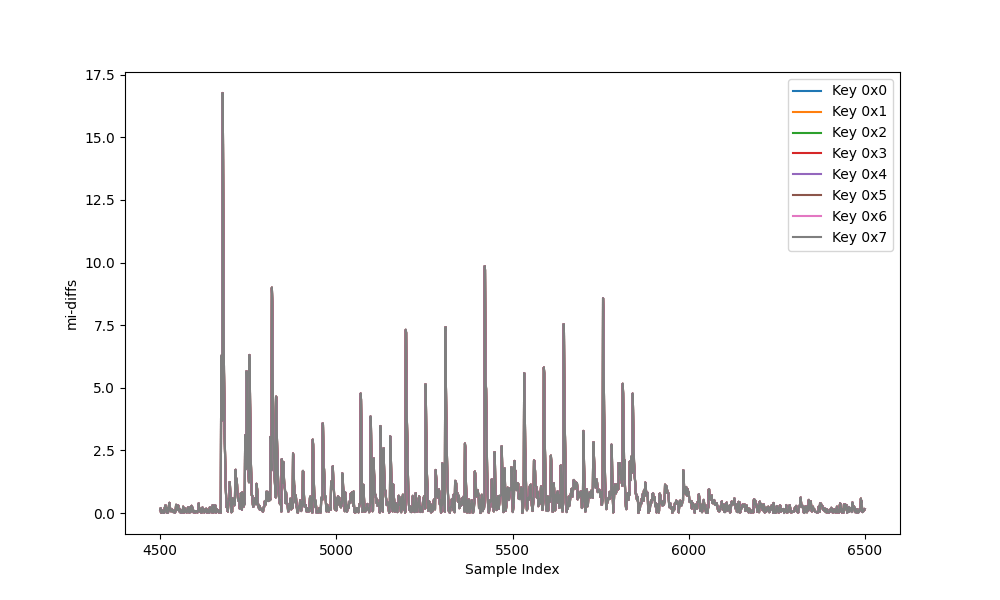

In [33]:
byte_pos = 4
bit_pos = 0

BYTE_VALUES = 8

L_matrix = np.empty((TRACE_CNT,BYTE_VALUES), dtype=np.byte)

print(f"...Processing {bit_pos}. bit")
for trace_number in range(TRACE_CNT):

    nonce_byte = NONCES[trace_number][byte_pos - 4]
    possible_values_vector = np.array([nonce_byte ^ ((possible_key_value + fixed_sigma[byte_pos]) & 0xFF) for possible_key_value in range(BYTE_VALUES)], dtype=np.byte)
    #extraction of X-th bit - [0000 000X] to [X000 0000]
    L_vector = np.array([ ((v1 & (0x01 << bit_pos)) >> bit_pos) for v1 in possible_values_vector], dtype=np.byte)
    L_matrix[trace_number, :] = L_vector

print(f"First 10 rows and 15 columns of L_matrix - {L_matrix.shape}:")
for row in L_matrix[:10, :15]:
    print(" ".join(f"{val:01x}" for val in row))

all_mi_diffs     = np.empty((BYTE_VALUES,len(TRACES_RANDOM[0])), dtype=np.float64)
all_mi_diffs_abs = np.empty((BYTE_VALUES,len(TRACES_RANDOM[0])), dtype=np.float64)

#pro kazdou moznou hodnotu klice 0...256
for i in range(BYTE_VALUES):
    # Split traces based on the value in L_matrix
    group_0 = TRACES_RANDOM[L_matrix[:, i] == 0]
    group_1 = TRACES_RANDOM[L_matrix[:, i] == 1]

    mi_traces_0 = np.mean(group_0, axis=0)
    mi_traces_1 = np.mean(group_1, axis=0)
    
    #Original Kocher’s approach
    mi_diffs = mi_traces_0 - mi_traces_1
    all_mi_diffs[i, :] = mi_diffs

    mi_diffs_abs = abs(mi_traces_0 - mi_traces_1)
    all_mi_diffs_abs[i, :] = mi_diffs_abs
    

mi_diff_max = np.unravel_index(all_mi_diffs_abs.argmax(), all_mi_diffs_abs.shape)
print(f"{hex(i)} -  Greatest diff for: {hex(mi_diff_max[0])} at sample index: {all_mi_diffs_abs[mi_diff_max[0]][mi_diff_max[1]]}")
    
    
# Plot all t-values arrays
plt.figure(figsize=(10, 6))
for idx, t_values in enumerate(all_t_values):
    plt.plot(all_mi_diffs_abs[i], label=f'Key {hex(idx)}')
    
# Adjust x-axis ticks to show values from 4500 to 6500
num_ticks = len(all_t_values[0])  # Assuming all_t_values arrays have the same length
plt.xticks(ticks=range(0, num_ticks, 500), labels=range(4500, 4500 + num_ticks, 500))

plt.xlabel('Sample Index')
plt.ylabel('mi-diffs')
plt.legend(loc='upper right')
plt.show()